In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
from random import shuffle, seed
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import copy
import cv2
import timm
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.optim import Adam
from torch.nn import BCELoss
from tqdm.notebook import tqdm
from torchinfo import summary
from torchvision import transforms
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
torch.manual_seed(42)
seed(42)

In [4]:
train_folder = 'Preprocessed_Scans'

In [5]:
train_metadata = 'train.csv'

In [6]:
train_df = pd.read_csv(train_metadata)

# Getting the CV-Setup done

The Training data will be split into 5 folds where each fold should contain roughtly the same number of cancer cases

For each patient the left and right breast can probably be placed in a different fold without causing any data leakage

In [7]:
''' This function returns the image_ids for five folds with balanced cancer to non-cancer cases
    To do this 5 lists for cancer scans & 5 lists for non-cancer scans are created
    The scans are assinged by looping over all patient_ids
    For each patient_id AND each breast, all scans are assined to the folder with the lowest amount of scan_ids
    After that the scan_ids for cancer & non-cancer are added up to 5 folds each
    The lengths are printed to make sure its balanced
'''

def get_folds_with_image_ids(DF):
    
    df = DF.copy()
    
    patient_ids = list(train_df['patient_id'].unique())  # all unique patient_ids
    shuffle(patient_ids)
    
    # foldes to hold the image ids
    cancer_fold_1, cancer_fold_2, cancer_fold_3, cancer_fold_4, cancer_fold_5 = [], [], [], [], []
    no_cancer_fold_1, no_cancer_fold_2, no_cancer_fold_3, no_cancer_fold_4, no_cancer_fold_5 = [], [], [], [], []
    
    # list of folders
    cancer_folders = [cancer_fold_1, cancer_fold_2, cancer_fold_3, cancer_fold_4, cancer_fold_5]
    no_cancer_folders = [no_cancer_fold_1, no_cancer_fold_2, no_cancer_fold_3, no_cancer_fold_4, no_cancer_fold_5]
    
    # loop over all patient ids and assign them to a fold (each patient + side must be in a single fold)
    for ID in tqdm(patient_ids):
        for side in ['L', 'R']:
            filt = (df['patient_id'] == ID) & (df['laterality'] == side)  # boolean df as filter
            
            # df only with the current patient id & one breast
            current_df = df[filt]
            
            # image ids which should be assigned to one fold
            values_to_assign = current_df['image_id'].values
            
            # array of cancer values from the selected df
            cancer_value = current_df['cancer'].unique()
            
            # should only contain one value!
            if len(cancer_value) > 1:
                print('\n\n\nERROR: GOT DIFFERENT CANCER VALUES!\n\n\n')
            else:
                cancer_value = cancer_value[0]
            
            # the image ids should be assigned to the folder with the least values
            
            if cancer_value == 0:  # add it to one of no cancer folders...
                len_folders = [len(folder) for folder in no_cancer_folders]
                folder = np.array(len_folders).argmin()  # ...to the one with the least values in it
                for image_id in values_to_assign:
                    no_cancer_folders[folder].append(image_id)
                    
            # same with cancer_values
            elif cancer_value == 1:
                len_folders = [len(folder) for folder in cancer_folders]
                folder = np.array(len_folders).argmin()  # the one with the least values
                for image_id in values_to_assign:
                    cancer_folders[folder].append(image_id)
            
    # check if the folders are balanced
    len_cancer_folders = [len(folder) for folder in cancer_folders]
    len_no_cancer_folders = [len(folder) for folder in no_cancer_folders]
    print(f'Length of cancer folders: {len_cancer_folders}')
    print(f'Length of non cancer folders: {len_no_cancer_folders}\n')

    # check if the values got assigned correct
    counted_cancer_cases = sum([len(folder) for folder in cancer_folders])
    number_cancer_cases = len(df[df['cancer'] == 1])
    print(f'Number of cancer cases in total: {number_cancer_cases}')
    print(f'Number of cancer cases in cancer folders: {counted_cancer_cases}\n')

    counted_no_cancer_cases = sum([len(folder) for folder in no_cancer_folders])
    number_no_cancer_cases = len(df[df['cancer'] == 0])
    print(f'Number of non cancer cases in total: {number_no_cancer_cases}')
    print(f'Number of non cancer cases in non cancer folders: {counted_no_cancer_cases}\n')

    # add them up to five folds & shuffle them again
    fold_1, fold_2, fold_3, fold_4, fold_5 = [cancer + no_cancer for cancer, no_cancer in
                                              zip(cancer_folders, no_cancer_folders)]
    [shuffle(fold) for fold in [fold_1, fold_2, fold_3, fold_4, fold_5]]

    # print final length
    print(f'Final Length of Folds: {[len(fold) for fold in [fold_1, fold_2, fold_3, fold_4, fold_5]]}')
            
    return fold_1, fold_2, fold_3, fold_4, fold_5

In [8]:
%%time
fold_1, fold_2, fold_3, fold_4, fold_5 = get_folds_with_image_ids(train_df)

  0%|          | 0/11913 [00:00<?, ?it/s]

Length of cancer folders: [234, 232, 230, 232, 230]
Length of non cancer folders: [10711, 10709, 10709, 10710, 10709]

Number of cancer cases in total: 1158
Number of cancer cases in cancer folders: 1158

Number of non cancer cases in total: 53548
Number of non cancer cases in non cancer folders: 53548

Final Length of Folds: [10945, 10941, 10939, 10942, 10939]
CPU times: user 53.2 s, sys: 52.4 ms, total: 53.2 s
Wall time: 53.2 s


#### These 5 folds will be used to create 5 training & 5 validation folds (allways with one hold out valid fold)

#### So basically 4 folds will be added up for training & the last one is the validation folder (5 fold cross validation)

## Augmentations based on paper

In [9]:
''' For image augmentation; Used the recommended ones from Page 5 in paper:
    Abdelhafiz, D., Bi, J., Ammar, R., Yang, C., & Nabavi, S. (2020). 
    Convolutional neural network for automated mass segmentation in mammography. BMC bioinformatics, 21(1), 1-19.
'''

augmentations = transforms.Compose([
    transforms.RandomRotation(10),  # rotate the image by -10 to +10 degree
    transforms.RandomHorizontalFlip(),  # flip it every 2nd time horizontally
    transforms.RandomVerticalFlip(),  # same vertically
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # shift 10 % left/right or up/down
    transforms.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.2))  # zoom in/out by 20%
])

## Pipeline for additional features

This preprocessing pipeline will be used for the additional featured

Not only the preprocessed scans will be used but also the view, age, implant and machine_id

Missing values need to be handled and they need to be scaled / encoded

In [10]:
num_attribs = ['age']  # numeric value
cat_attribs = ['view', 'implant', 'machine_id']  # categorical values (implant for simplicitly too)

In [11]:
num_pipeline = Pipeline([
    ('Imputer_Median_Num', SimpleImputer(strategy='median')),  # fill Na with median value
    ('Standardize_Num', StandardScaler())  # scale age to mean 0 and std 1
])

In [12]:
cat_pipeline = Pipeline([
    ('Imputer_Median_Cat', SimpleImputer(strategy='most_frequent')),  # fill Na with most frequent
    ('OneHot', OneHotEncoder(sparse=False))  # create one-hot array and dont return sparse matrix
])

In [13]:
num_cat_pipeline = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_attribs),
    ('cat_pipeline', cat_pipeline, cat_attribs)
])

In [14]:
df_for_fitting = train_df[['age', 'view', 'implant', 'machine_id']].copy()

In [15]:
num_cat_pipeline.fit(df_for_fitting)

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('Imputer_Median_Num',
                                                  SimpleImputer(strategy='median')),
                                                 ('Standardize_Num',
                                                  StandardScaler())]),
                                 ['age']),
                                ('cat_pipeline',
                                 Pipeline(steps=[('Imputer_Median_Cat',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('OneHot',
                                                  OneHotEncoder(sparse=False))]),
                                 ['view', 'implant', 'machine_id'])])

See output (example):

In [16]:
example_out = num_cat_pipeline.transform(df_for_fitting.iloc[:5, :])

In [17]:
example_out

array([[ 0.24441783,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.24441783,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.24441783,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.24441783,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.   

In [18]:
example_out.shape

(5, 19)

So 19 additional features will be added together with the output of the pretrained-network with the scans

## Create the dataset

In [19]:
''' Each Dataset will be initialized with the image ids of the corresponding fold that are defined laster
    The Train-Dataframe will be filtered based on the image_ids of the fold
    PROBLEM: The filtered Dataframe does not have the same order as the assined image_ids
    -> It needs to be sorted by the image_ids
    Each Index return the preprocessed and augmented scan from the last notebook as well as the additional featured
    The features are also preprocessed based on the pipeline above
'''


class Data(Dataset):
    
    # same initialization
    def __init__(self, fold_image_ids, DF, pipe, transform=None):
        self.df = DF.copy()
        
        self.transform = transform
        self.pipe = pipe
        
        self.image_ids = copy.deepcopy(fold_image_ids)  # dont shuffle original
        shuffle(self.image_ids)  # shuffle new image ids
        
        self.df_filtered = self.df[self.df['image_id'].isin(self.image_ids)]  # get df with initialized image_ids
        
        # Problem: The new dataframe should be sorted with the new image_ids to get the correct other values
        self.df_sorted = self.df_filtered.iloc[np.argsort([self.image_ids.index(i) for i in 
                                                           self.df_filtered['image_id']])]
        
        # get the cancer value for each image id
        self.targets = list(self.df_sorted['cancer'].values)
        
        # make df for pipeline
        self.df_pipe = self.df_sorted[['age', 'view', 'implant', 'machine_id']].copy()
        self.encoded = self.pipe.transform(self.df_pipe)  # these ancoded values can be grabed by index in getitem
        
        # also get the corresponding patient_ids for correct assignment below
        self.patient_ids = list(self.df_sorted['patient_id'].values)
                                              
        self.n_samples = len(self.image_ids)
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        
        # get the correct scan of the preprocessed data
        folder = train_folder
        
        patient_id = str(self.patient_ids[index])
        image_id = str(self.image_ids[index])
        
        file_name = f'{patient_id}_{image_id}.pickle'  # new file name with new type
        
        path_img = os.path.join(folder, file_name)  # path to each image id
        
        with open(path_img, 'rb') as f:
            X = pickle.load(f)
        
        if self.transform is not None:
            X = self.transform(X)
        
        # to feed the grayscaled tensor into a pretrained rgb-model repeat the tensor 3 times in dim 0
        X = X.repeat(3, 1, 1)
        
        y = torch.tensor(self.targets[index]).type(torch.float32)
        
        add_features = torch.Tensor(self.encoded[index]).type(torch.float32)
        
        
        return (X, add_features), y

## Class weights for upsampling cancer cases

In [20]:
def get_class_weights(DF):
    df = DF.copy()
    
    num_cancer_cases = len(df[df['cancer'] == 1])
    num_no_cancer_cases = len(df[df['cancer'] == 0])
    
    # the class weights just need to have a correct relative size
    # class weight for no cancer cases is set as 1 -> cancer cases weight is the number they appear less
    no_cancer_weight = 1
    cancer_weight = round(num_no_cancer_cases / num_cancer_cases, 2)
    
    print(f'Weights: No Cancer: {no_cancer_weight}; Cancer: {cancer_weight}')
    
    return [no_cancer_weight, cancer_weight]

In [21]:
class_weights = get_class_weights(train_df)

Weights: No Cancer: 1; Cancer: 46.24


# Building the model (Combining EfficientNet with a Custom Model)

In [22]:
model_1 = timm.create_model('tf_efficientnetv2_xl_in21k', pretrained=True).to(device)

In [23]:
# make pretrained model weights untrainable
for param in model_1.parameters():
    param.requires_grad = False

In [24]:
summary(model_1, input_data=torch.randn((2, 3, 512, 512)))

Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  [2, 21843]                --
├─Conv2dSame: 1-1                             [2, 32, 256, 256]         (864)
├─BatchNormAct2d: 1-2                         [2, 32, 256, 256]         64
│    └─Identity: 2-1                          [2, 32, 256, 256]         --
│    └─SiLU: 2-2                              [2, 32, 256, 256]         --
├─Sequential: 1-3                             [2, 640, 16, 16]          --
│    └─Sequential: 2-3                        [2, 32, 256, 256]         --
│    │    └─ConvBnAct: 3-1                    [2, 32, 256, 256]         (9,280)
│    │    └─ConvBnAct: 3-2                    [2, 32, 256, 256]         (9,280)
│    │    └─ConvBnAct: 3-3                    [2, 32, 256, 256]         (9,280)
│    │    └─ConvBnAct: 3-4                    [2, 32, 256, 256]         (9,280)
│    └─Sequential: 2-4                        [2, 64, 128, 128]         

In [25]:
# Identity layer to replace the Classification layer in EfficientNet

class Identity(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [26]:
identity = Identity()

In [27]:
model_1.classifier = identity  # puts it on gpu by default

Now an additional model must be created that takes as input the EffNet output as well as the additional features

In [28]:
# Second model that takes as inout the efficientnet output and the additional featured from the dataset

class Second_Model(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.fc_1 = nn.Linear(1280, 32)
        self.bn_1 = nn.BatchNorm1d(32)
        self.act_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.25)
        
        self.fc_2 = nn.Linear(51, 8)  # 51 with added features (32 + 19add_features)
        self.bn_2 = nn.BatchNorm1d(8)
        self.act_2 = nn.ReLU()
        self.drop_2 = nn.Dropout(0.25)
        
        self.fc_3 = nn.Linear(8, 1)
        self.out = nn.Sigmoid()
    
    # add view, age, implant and machine_id as features
    # view, implants and machine id will be one hot encoded (6, 2, 10 values)
    # age single scalar  -> 19 additional values added at 
    def forward(self, x, add_features):

        x = self.fc_1(x)
        x = self.bn_1(x)
        x = self.act_1(x)
        x = self.drop_1(x)

        x = torch.cat((x, add_features), dim=1)

        x = self.fc_2(x)
        x = self.bn_2(x)
        x = self.act_2(x)
        x = self.drop_2(x)
        
        x = self.fc_3(x)
        x = self.out(x)
        
        return x

In [29]:
model_2 = Second_Model()

In [30]:
model_2.to(device)

Second_Model(
  (fc_1): Linear(in_features=1280, out_features=32, bias=True)
  (bn_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_1): ReLU()
  (drop_1): Dropout(p=0.25, inplace=False)
  (fc_2): Linear(in_features=51, out_features=8, bias=True)
  (bn_2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_2): ReLU()
  (drop_2): Dropout(p=0.25, inplace=False)
  (fc_3): Linear(in_features=8, out_features=1, bias=True)
  (out): Sigmoid()
)

In [31]:
# Combined model that consists of model_1 and model_2

class Combined_Model(torch.nn.Module):
    def __init__(self, MODEL_1, MODEL_2):
        super().__init__()
        self.model_1 = model_1
        self.model_2 = model_2
        
    def forward(self, x, add_features):
        
        x = self.model_1(x)
        
        x = model_2(x, add_features)
        
        return x

In [32]:
comb_model = Combined_Model(MODEL_1=model_1, MODEL_2=model_2).to(device)

In [33]:
summary(comb_model, input_data=(torch.randn(2, 3, 512, 512).to(device), torch.randn(2, 19).to(device)))

Layer (type:depth-idx)                             Output Shape              Param #
Combined_Model                                     [2, 1]                    --
├─EfficientNet: 1-1                                [2, 1280]                 --
│    └─Conv2dSame: 2-1                             [2, 32, 256, 256]         (864)
│    └─BatchNormAct2d: 2-2                         [2, 32, 256, 256]         64
│    │    └─Identity: 3-1                          [2, 32, 256, 256]         --
│    │    └─SiLU: 3-2                              [2, 32, 256, 256]         --
│    └─Sequential: 2-3                             [2, 640, 16, 16]          --
│    │    └─Sequential: 3-3                        [2, 32, 256, 256]         (37,120)
│    │    └─Sequential: 3-4                        [2, 64, 128, 128]         (1,196,800)
│    │    └─Sequential: 3-5                        [2, 96, 64, 64]           (2,759,936)
│    │    └─Sequential: 3-6                        [2, 192, 32, 32]          (5,832,168)

### Save initial (random) weights

In [34]:
initial_weights = 'MODEL_INITIAL_WEIGHTS.pth'
torch.save(comb_model.state_dict(), initial_weights)

Saved model weights will be used to start every cv-folder with a newly initialized model

# Training and validation functions (loss and pF1-Score)

In [35]:
'''Function for predicting a batch, calculating the loss,
   calculate the gradients & adjust weights'''

def train_batch(model, loss, optimizer, X, add_features, y):
    model.train()  # set model to training mode

    pred = model(X, add_features)  # prediction for current batch features
    
    pred = pred.clip(0.05, 0.95)  # set a threshold
    
    pred = pred.squeeze()  # remove batch size dim
    
    weight_indices = y.int()  # make y the weight indices (need to be int not float)
    
    weights = torch.Tensor([class_weights[i] for i in weight_indices]).to(device)  # loss weight
    
    loss.weight = weights  # assign it
    
    batch_loss = loss(pred, y)  # calculate loss
    
    batch_loss.backward()  # backpropagate
    
    optimizer.step()  # adjust trainable weights
    
    optimizer.zero_grad()  # remove gradients for next batch
    
    return batch_loss.item()  # return loss value 

In [36]:
'''Function for calculating validation loss without adjusting the weights'''

@torch.no_grad()
def calculate_val_loss(model, loss, X, add_features, y):
    model.eval()  # evaluation mode
    
    pred = model(X, add_features)
    
    pred = pred.squeeze()
    
    pred = pred.clip(0.05, 0.95)
    
    weight_indices = y.int()
    
    weights = torch.Tensor([class_weights[i] for i in weight_indices]).to(device)
    
    loss.weight = weights
    
    batch_loss = loss(pred, y)
    
    return batch_loss.item()  # just return the loss for evaluation

In [37]:
'''Takes as input a batch (tensor) and returns the pF1 score'''

def pF1(labels, preds, beta=1):
    preds = preds.clip(0, 1)  # make sure predictions are between 0 and 1
    y_true_count = labels.sum()  # number of true positive is the sum of labels (since false is 0 - no cancer)
    ctp = preds[labels==1].sum()  # count of true positive scores (sum the values)
    cfp = preds[labels==0].sum()  # count of false positives (sum where predictions should be 0)
    beta_squared = beta * beta
    # calculate precision & recall for the pF1 score
    c_precision = ctp / (ctp + cfp + 1e-4)  # add epsilon so there is no zero division error
    c_recall = ctp / (y_true_count + 1e-4)
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + 1e-4)
        return float(result.cpu())  # should be a python float like loss.item()
    else:
        return 0.0  # this is prob. the reason why score with a batch_size of 32 is very low

In [38]:
'''Calculate the pF1 score for a single batch without weight adjustments'''

@torch.no_grad()
def calculate_pF1(model, X, add_features, y):
    model.eval()    
    
    pred = model(X, add_features)
    
    pred = pred.squeeze()
    
    pred = pred.clip(0.05, 0.95)
    
    pF1_score = pF1(labels=y, preds=pred)
    
    return pF1_score

# Create the 5 training- & validation-folds 

#### Each folds once is the validation fold; rest is for training

In [39]:
%%time
'''First set up the CV, so that each fold once is the validation folder and the rest of the folds is used for train
   For that create the datasets and dataloaders for each fold, otherwise they need to be created 
   (epochs * fold) times which takes quite some time (~100s * epochs)
'''
folds = [fold_1, fold_2, fold_3, fold_4, fold_5]  # all 5 folds created above

# variable names for assignment
train_ds_names = ['train_ds_1', 'train_ds_2', 'train_ds_3', 'train_ds_4', 'train_ds_5']
valid_ds_names = ['valid_ds_1', 'valid_ds_2', 'valid_ds_3', 'valid_ds_4', 'valid_ds_5']

#fold ==  5, 4, 3, 2, 1 for current val fold index
for fold, tr_ds, val_ds in tqdm(zip(range(len(folds), 0, -1), train_ds_names, valid_ds_names)):
    
    val_fold_index = fold - 1  # index of current val fold
    train_fold_indices = list(range(0, len(folds)))  # all fold indices
    train_fold_indices.remove(val_fold_index)  # all training folds (current val fold excluded)

    train_image_ids = []
    for index in train_fold_indices:
        train_image_ids += folds[index]  # add images ids of each train folds up

    val_image_ids = folds[val_fold_index]

    # create the datasets for the current folders & assign them to a global variable to keep them
    globals()[tr_ds] = Data(fold_image_ids=train_image_ids, DF=train_df, transform=augmentations, pipe=num_cat_pipeline)
    globals()[val_ds] = Data(fold_image_ids=val_image_ids, DF=train_df, pipe=num_cat_pipeline)

0it [00:00, ?it/s]

CPU times: user 1min 40s, sys: 35.8 ms, total: 1min 40s
Wall time: 1min 40s


## Check for each validation folder if any image_id is in the corresponding training folder

In [40]:
train_datasets = [train_ds_1, train_ds_2, train_ds_3, train_ds_4, train_ds_5]
valid_datasets = [valid_ds_1, valid_ds_2, valid_ds_3, valid_ds_4, valid_ds_5]

max_len = len(train_df)

for fold, train_ds, valid_ds in zip(range(len(train_datasets)), train_datasets, valid_datasets):
    tr_image_ids = train_ds.image_ids
    val_image_ids = valid_ds.image_ids
    total_ids = len(tr_image_ids) + len(val_image_ids)
    
    print(f'Fold {fold}: Image IDs is equal to all IDs: {max_len == total_ids} ({max_len}=={total_ids})')
    
    counter = 0
    
    for val_image_id in val_image_ids:
        in_train = tr_image_ids.count(val_image_id)  # number of times val_image_id is in train_image_ids
        counter += in_train
        
    print(f'Training-Fold {fold} contains {counter} of valid image IDs\n')

Fold 0: Image IDs is equal to all IDs: True (54706==54706)
Training-Fold 0 contains 0 of valid image IDs

Fold 1: Image IDs is equal to all IDs: True (54706==54706)
Training-Fold 1 contains 0 of valid image IDs

Fold 2: Image IDs is equal to all IDs: True (54706==54706)
Training-Fold 2 contains 0 of valid image IDs

Fold 3: Image IDs is equal to all IDs: True (54706==54706)
Training-Fold 3 contains 0 of valid image IDs

Fold 4: Image IDs is equal to all IDs: True (54706==54706)
Training-Fold 4 contains 0 of valid image IDs



# Creating the DataLoaders

In [41]:
tr_dl_names = ['train_dl_1', 'train_dl_2', 'train_dl_3', 'train_dl_4', 'train_dl_5']
val_dl_names = ['valid_dl_1', 'valid_dl_2', 'valid_dl_3', 'valid_dl_4', 'valid_dl_5']

for train_ds, valid_ds, train_dl, valid_dl in tqdm(zip(train_datasets, valid_datasets, tr_dl_names, val_dl_names)):
        
    globals()[train_dl] = DataLoader(train_ds, batch_size=32, num_workers=24, pin_memory=True, drop_last=True)
                                     #, multiprocessing_context='spawn')
    
    globals()[valid_dl] = DataLoader(valid_ds, batch_size=32, num_workers=24, pin_memory=True, drop_last=True)
                                    #, multiprocessing_context='spawn')

0it [00:00, ?it/s]

# Train 5 models with the dl & functions above

In [42]:
%%time
''' Train 5 models for 12 epochs each with the train/valid-dl created
    Each model is starts with random weights
    After training the saved metrics from train/valid are written to a df and saved
    The model weights are saved as well before they are reset in the next iteration
'''

num_epochs = 12

train_dataloaders = [train_dl_1, train_dl_2, train_dl_3, train_dl_4, train_dl_5]
valid_dataloaders = [valid_dl_1, valid_dl_2, valid_dl_3, valid_dl_4, valid_dl_5]

df_metrics = pd.DataFrame()  # add metrics for each model after training and save them to csv

for fold in range(5):  # for each fold train the model, evaluate it & save weights/metrics
    
    print(f'FOLD {fold + 1} / 5')
    
    train_epoch_losses, valid_epoch_losses = [], []
    train_epoch_pF1s, valid_epoch_pF1s = [], []
    
    model_name = f'model_{fold + 1}'
    
    comb_model.load_state_dict(torch.load(initial_weights))  # load initial weights for each cv-fold
    
    loss_bce = BCELoss(weight=torch.Tensor(class_weights))  # correct weights assinged in train/val functions
    optimizer = Adam(comb_model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

    train_dl = train_dataloaders[fold]  # current loaders for fold
    valid_dl = valid_dataloaders[fold]
    
    for epoch in tqdm(range(num_epochs)):
        
        train_loss, valid_loss = [], []  # metric after each epoch for current model
        train_pF1, valid_pF1 = [], []
        
        # train with all available batches
        for index, ((X, add_features), y) in enumerate(train_dl):
            X = X.to(device)
            add_features = add_features.to(device)
            y = y.to(device)
            batch_loss = train_batch(model=comb_model, loss=loss_bce, optimizer=optimizer, X=X,
                                     add_features=add_features, y=y)
            train_loss.append(batch_loss)
        print(f'Finished Epoch {epoch + 1}/{num_epochs} - Training')

        # calculate pF1-score for all training data
        for index, ((X, add_features), y) in enumerate(train_dl):
            X = X.to(device)
            add_features = add_features.to(device)
            y = y.to(device)
            batch_pF1 = calculate_pF1(model=comb_model, X=X,add_features=add_features, y=y)
            train_pF1.append(batch_pF1)
        print(f'Finished Epoch {epoch + 1}/{num_epochs} - Training_pF1_Evaluation')

        # calculate loss for all valid data
        for index, ((X, add_features), y) in enumerate(valid_dl):
            X = X.to(device)
            add_features = add_features.to(device)
            y = y.to(device)
            batch_loss = calculate_val_loss(model=comb_model, loss=loss_bce, X=X, add_features=add_features, y=y)
            valid_loss.append(batch_loss)

        print(f'Finished Epoch {epoch + 1}/{num_epochs} - Loss_Validation')

        # calculate pF1-score for all valid data
        for index, ((X, add_features), y) in enumerate(valid_dl):
            X = X.to(device)
            add_features = add_features.to(device)
            y = y.to(device)
            batch_pF1 = calculate_pF1(model=comb_model, X=X, add_features=add_features, y=y)
            valid_pF1.append(batch_pF1)
        print(f'Finished Epoch {epoch + 1}/{num_epochs} - pF1_Validation')

        # after training & validating each fold, append the mean values to the lists & continue with the next epoch
        train_epoch_loss = np.array(train_loss).mean()
        train_epoch_pF1 = np.array(train_pF1).mean()
        valid_epoch_loss = np.array(valid_loss).mean()
        valid_epoch_pF1 = np.array(valid_pF1).mean()

        print(f'Train: Loss: {train_epoch_loss}, pF1: {train_epoch_pF1}')
        print(f'Valid: Loss: {valid_epoch_loss}, pF1: {valid_epoch_pF1}')

        train_epoch_losses.append(train_epoch_loss)
        train_epoch_pF1s.append(train_epoch_pF1)
        valid_epoch_losses.append(valid_epoch_loss)
        valid_epoch_pF1s.append(valid_epoch_pF1)

        scheduler.step(valid_epoch_loss)
    
    torch.save(comb_model.state_dict(), f'{model_name}.pth')  # save trained weights
    
    df_metrics[model_name + '_train_loss'] = train_epoch_losses
    df_metrics[model_name + '_train_pF1'] = train_epoch_pF1s
    df_metrics[model_name + '_valid_loss'] = valid_epoch_losses
    df_metrics[model_name + '_valid_pF1'] = valid_epoch_pF1s
    
    df_metrics.to_csv('Saved_Model_Metrics.csv')

FOLD 1 / 5


  0%|          | 0/12 [00:00<?, ?it/s]

Finished Epoch 1/12 - Training
Finished Epoch 1/12 - Training_pF1_Evaluation
Finished Epoch 1/12 - Loss_Validation
Finished Epoch 1/12 - pF1_Validation
Train: Loss: 1.3601753381629362, pF1: 0.04044706181704115
Valid: Loss: 1.3957690509183664, pF1: 0.03964044351289131
Finished Epoch 2/12 - Training
Finished Epoch 2/12 - Training_pF1_Evaluation
Finished Epoch 2/12 - Loss_Validation
Finished Epoch 2/12 - pF1_Validation
Train: Loss: 1.3185216221132676, pF1: 0.04196262179929068
Valid: Loss: 1.3917809044860325, pF1: 0.04133936843924945
Finished Epoch 3/12 - Training
Finished Epoch 3/12 - Training_pF1_Evaluation
Finished Epoch 3/12 - Loss_Validation
Finished Epoch 3/12 - pF1_Validation
Train: Loss: 1.3055803729132658, pF1: 0.04264525494837334
Valid: Loss: 1.3743464168914952, pF1: 0.04141586230346753
Finished Epoch 4/12 - Training
Finished Epoch 4/12 - Training_pF1_Evaluation
Finished Epoch 4/12 - Loss_Validation
Finished Epoch 4/12 - pF1_Validation
Train: Loss: 1.2851011988099859, pF1: 0.0434

  0%|          | 0/12 [00:00<?, ?it/s]

Finished Epoch 1/12 - Training
Finished Epoch 1/12 - Training_pF1_Evaluation
Finished Epoch 1/12 - Loss_Validation
Finished Epoch 1/12 - pF1_Validation
Train: Loss: 1.3550841752507867, pF1: 0.04063786946519141
Valid: Loss: 1.4531251772407912, pF1: 0.038833390634583416
Finished Epoch 2/12 - Training
Finished Epoch 2/12 - Training_pF1_Evaluation
Finished Epoch 2/12 - Loss_Validation
Finished Epoch 2/12 - pF1_Validation
Train: Loss: 1.329253738390414, pF1: 0.041482227932778955
Valid: Loss: 1.4529013811143612, pF1: 0.039686706192966256
Finished Epoch 3/12 - Training
Finished Epoch 3/12 - Training_pF1_Evaluation
Finished Epoch 3/12 - Loss_Validation
Finished Epoch 3/12 - pF1_Validation
Train: Loss: 1.3043438749934255, pF1: 0.04226896345605849
Valid: Loss: 1.4111802701201956, pF1: 0.041186393728845715
Finished Epoch 4/12 - Training
Finished Epoch 4/12 - Training_pF1_Evaluation
Finished Epoch 4/12 - Loss_Validation
Finished Epoch 4/12 - pF1_Validation
Train: Loss: 1.2937128416534402, pF1: 0.0

  0%|          | 0/12 [00:00<?, ?it/s]

Finished Epoch 1/12 - Training
Finished Epoch 1/12 - Training_pF1_Evaluation
Finished Epoch 1/12 - Loss_Validation
Finished Epoch 1/12 - pF1_Validation
Train: Loss: 1.3630436853762518, pF1: 0.04023857612637006
Valid: Loss: 1.3712425349045358, pF1: 0.04007411805798144
Finished Epoch 2/12 - Training
Finished Epoch 2/12 - Training_pF1_Evaluation
Finished Epoch 2/12 - Loss_Validation
Finished Epoch 2/12 - pF1_Validation
Train: Loss: 1.3290031770763384, pF1: 0.04142889220215756
Valid: Loss: 1.3654463712420981, pF1: 0.04021836815216193
Finished Epoch 3/12 - Training
Finished Epoch 3/12 - Training_pF1_Evaluation
Finished Epoch 3/12 - Loss_Validation
Finished Epoch 3/12 - pF1_Validation
Train: Loss: 1.3053233486592726, pF1: 0.04232450900156522
Valid: Loss: 1.3768360846378236, pF1: 0.04073533113319372
Finished Epoch 4/12 - Training
Finished Epoch 4/12 - Training_pF1_Evaluation
Finished Epoch 4/12 - Loss_Validation
Finished Epoch 4/12 - pF1_Validation
Train: Loss: 1.286768279724428, pF1: 0.04290

  0%|          | 0/12 [00:00<?, ?it/s]

Finished Epoch 1/12 - Training
Finished Epoch 1/12 - Training_pF1_Evaluation
Finished Epoch 1/12 - Loss_Validation
Finished Epoch 1/12 - pF1_Validation
Train: Loss: 1.3578395096158666, pF1: 0.040664259151875125
Valid: Loss: 1.4278455352153945, pF1: 0.04057397056900817
Finished Epoch 2/12 - Training
Finished Epoch 2/12 - Training_pF1_Evaluation
Finished Epoch 2/12 - Loss_Validation
Finished Epoch 2/12 - pF1_Validation
Train: Loss: 1.3164673452405224, pF1: 0.04212355481572422
Valid: Loss: 1.4686968462907675, pF1: 0.03972516556562654
Finished Epoch 3/12 - Training
Finished Epoch 3/12 - Training_pF1_Evaluation
Finished Epoch 3/12 - Loss_Validation
Finished Epoch 3/12 - pF1_Validation
Train: Loss: 1.3041884576916782, pF1: 0.0431185817167479
Valid: Loss: 1.4545195197080238, pF1: 0.040332322585180706
Finished Epoch 4/12 - Training
Finished Epoch 4/12 - Training_pF1_Evaluation
Finished Epoch 4/12 - Loss_Validation
Finished Epoch 4/12 - pF1_Validation
Train: Loss: 1.2835647004227964, pF1: 0.044

  0%|          | 0/12 [00:00<?, ?it/s]

Finished Epoch 1/12 - Training
Finished Epoch 1/12 - Training_pF1_Evaluation
Finished Epoch 1/12 - Loss_Validation
Finished Epoch 1/12 - pF1_Validation
Train: Loss: 1.3572921342629976, pF1: 0.040769791122574985
Valid: Loss: 1.4183310402764215, pF1: 0.03936721107715534
Finished Epoch 2/12 - Training
Finished Epoch 2/12 - Training_pF1_Evaluation
Finished Epoch 2/12 - Loss_Validation
Finished Epoch 2/12 - pF1_Validation
Train: Loss: 1.3140769763505624, pF1: 0.041805148377793824
Valid: Loss: 1.4072618401712842, pF1: 0.039981280683610614
Finished Epoch 3/12 - Training
Finished Epoch 3/12 - Training_pF1_Evaluation
Finished Epoch 3/12 - Loss_Validation
Finished Epoch 3/12 - pF1_Validation
Train: Loss: 1.2996965348502538, pF1: 0.042967622444965624
Valid: Loss: 1.3706101520716796, pF1: 0.04097290697088193
Finished Epoch 4/12 - Training
Finished Epoch 4/12 - Training_pF1_Evaluation
Finished Epoch 4/12 - Loss_Validation
Finished Epoch 4/12 - pF1_Validation
Train: Loss: 1.285701145459547, pF1: 0.0

# Plot the results of each model

In [43]:
df_metrics.head()

,model_1_train_loss,model_1_train_pF1,model_1_valid_loss,model_1_valid_pF1,model_2_train_loss,model_2_train_pF1,model_2_valid_loss,model_2_valid_pF1,model_3_train_loss,model_3_train_pF1,model_3_valid_loss,model_3_valid_pF1,model_4_train_loss,model_4_train_pF1,model_4_valid_loss,model_4_valid_pF1,model_5_train_loss,model_5_train_pF1,model_5_valid_loss,model_5_valid_pF1
0,1.360175,0.040447,1.395769,0.039640,1.355084,0.040638,1.453125,0.038833,1.363044,0.040239,1.371243,0.040074,1.357840,0.040664,1.427846,0.040574,1.357292,0.040770,1.418331,0.039367
1,1.318522,0.041963,1.391781,0.041339,1.329254,0.041482,1.452901,0.039687,1.329003,0.041429,1.365446,0.040218,1.316467,0.042124,1.468697,0.039725,1.314077,0.041805,1.407262,0.039981
2,1.305580,0.042645,1.374346,0.041416,1.304344,0.042269,1.411180,0.041186,1.305323,0.042325,1.376836,0.040735,1.304188,0.043119,1.454520,0.040332,1.299697,0.042968,1.370610,0.040973
3,1.285101,0.043494,1.389714,0.041550,1.293713,0.042803,1.399853,0.042301,1.286768,0.042907,1.369318,0.040935,1.283565,0.044073,1.446788,0.040315,1.285701,0.043597,1.358001,0.042304
4,1.276053,0.044774,1.407305,0.040855,1.286082,0.043752,1.433649,0.041606,1.284686,0.044351,1.360222,0.042019,1.262823,0.045250,1.436517,0.041693,1.275420,0.044591,1.348661,0.042669


In [44]:
df_metrics.columns

Index(['model_1_train_loss', 'model_1_train_pF1', 'model_1_valid_loss',
       'model_1_valid_pF1', 'model_2_train_loss', 'model_2_train_pF1',
       'model_2_valid_loss', 'model_2_valid_pF1', 'model_3_train_loss',
       'model_3_train_pF1', 'model_3_valid_loss', 'model_3_valid_pF1',
       'model_4_train_loss', 'model_4_train_pF1', 'model_4_valid_loss',
       'model_4_valid_pF1', 'model_5_train_loss', 'model_5_train_pF1',
       'model_5_valid_loss', 'model_5_valid_pF1'],
      dtype='object')

In [47]:
metric_names = df_metrics.columns
loss_names = metric_names[0::2]  # loss names in df
pF1_names = metric_names[1::2]
model_names = ['Model_' + str(i) for i in range(1, 6)]
X_values = list(df_metrics.index + 1)  # 1-12
loss_train_valid = [[i, j] for i, j in zip(loss_names[0::2], loss_names[1::2])]
pF1_train_valid = [[i, j] for i, j in zip(pF1_names[0::2], pF1_names[1::2])]

Text(0.5, 0.91, 'Results of train/valid loss & pF1-score for all 5 models')

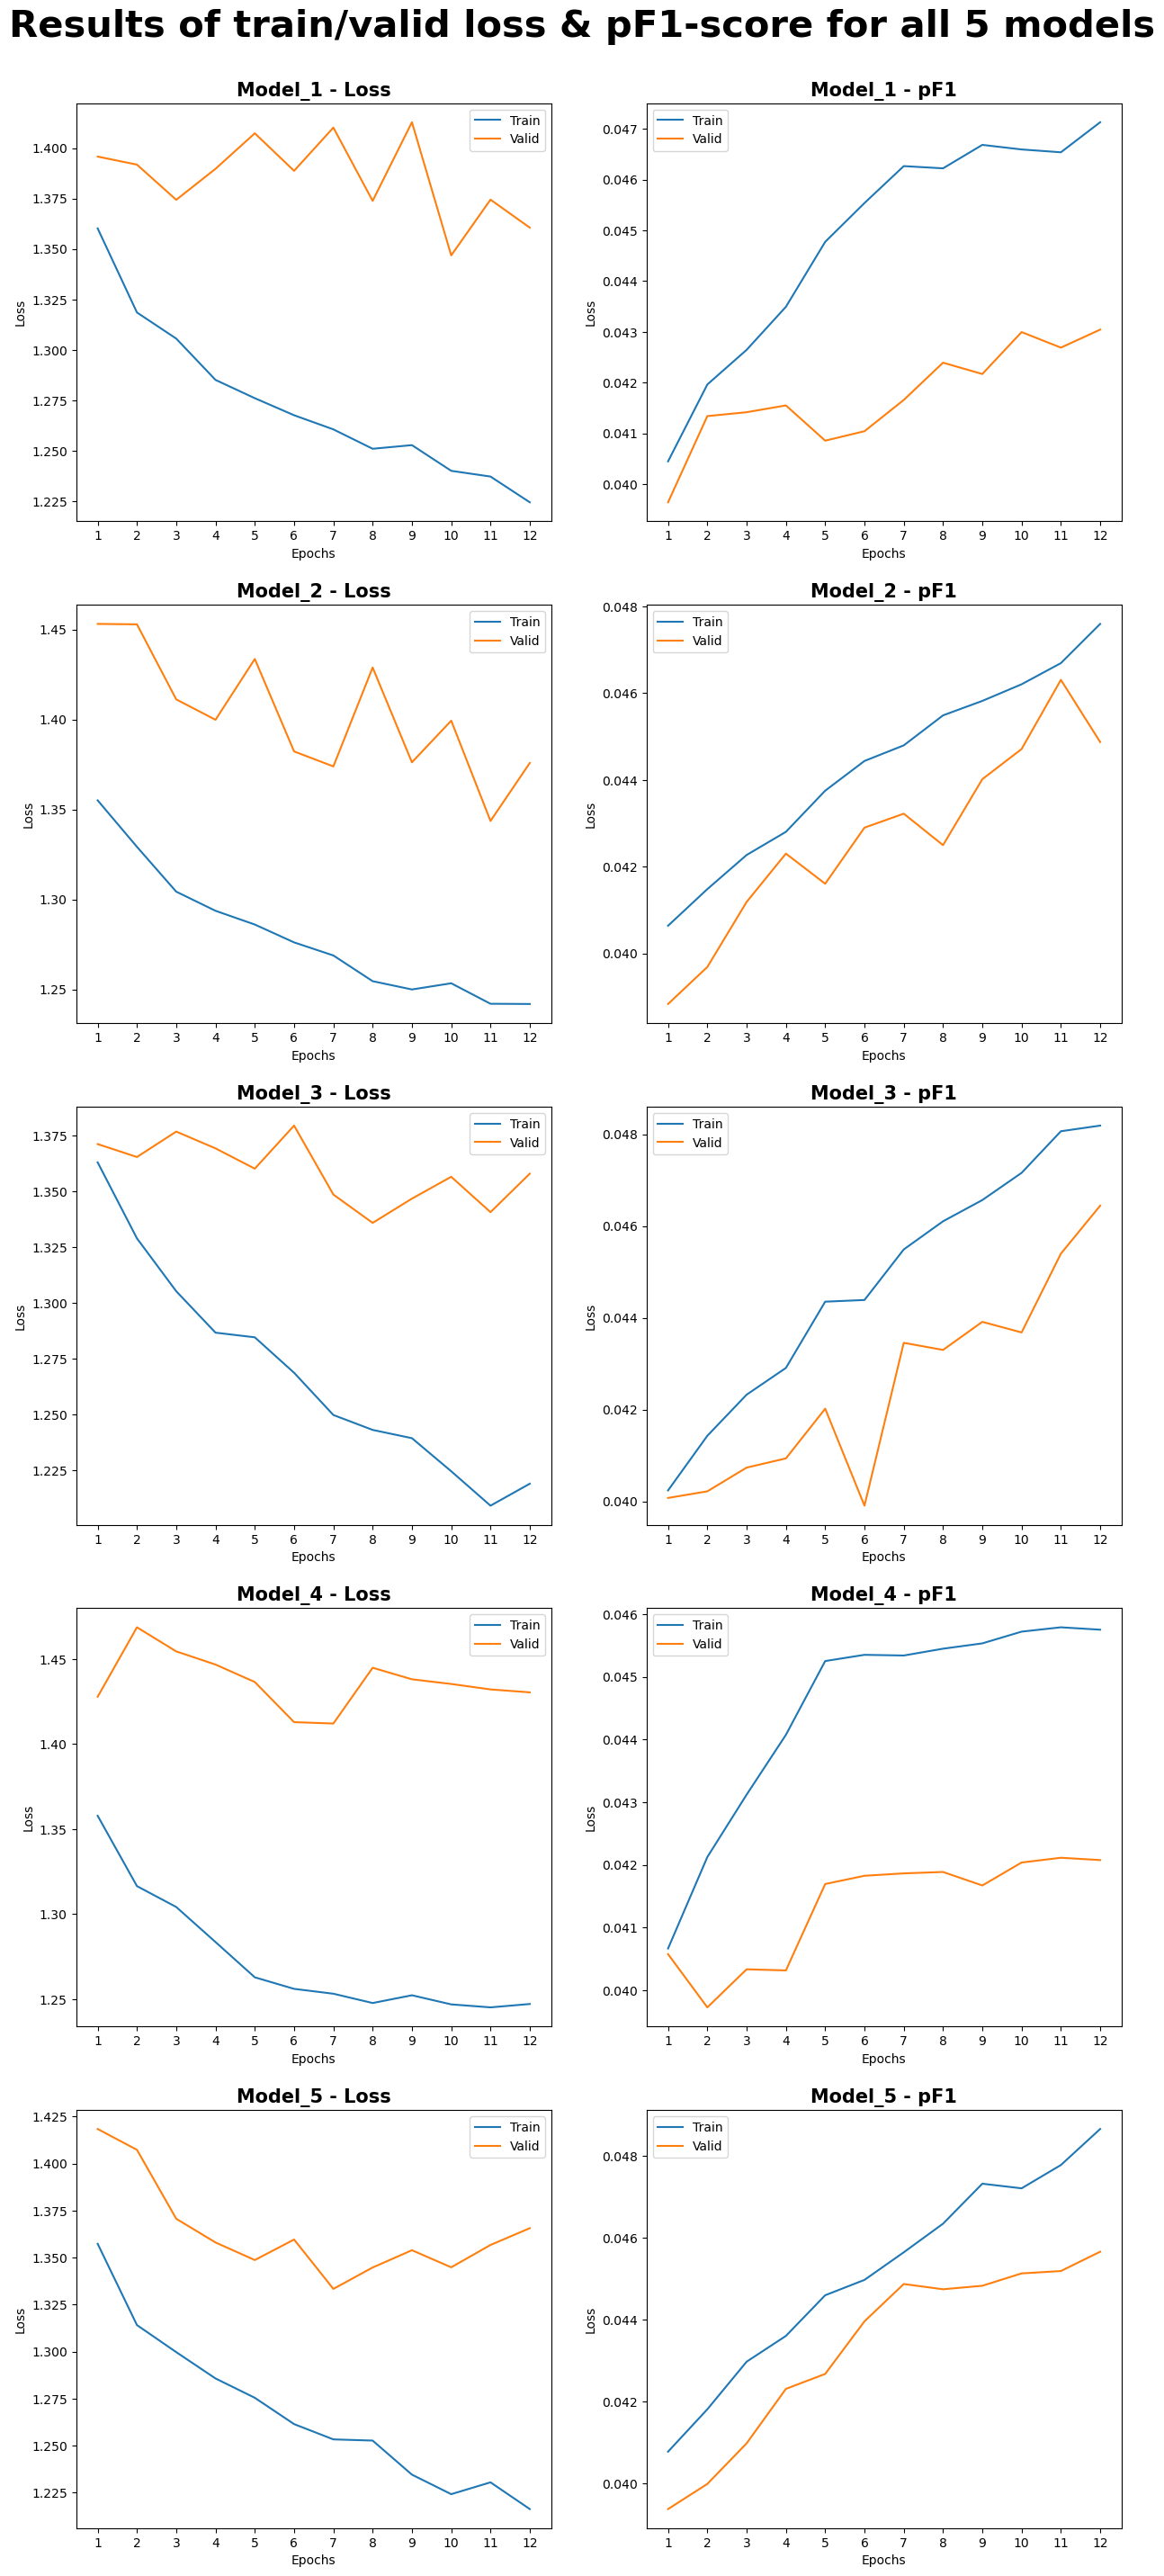

In [48]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 35))
for col in range(2):
    for row in range(5):
        if col==0:  # plot loss
            y_LABEL = 'Loss'
            for i in range(2):  # plot both corresponding train & valid values for one model in the same graph
                name = loss_train_valid[row][i]
                ax[row, col].plot(X_values, df_metrics[name].values)
                ax[row, col].set_xlabel('Epochs')
                ax[row, col].set_ylabel('Loss')
                ax[row, col].set_title(model_names[row] + ' - Loss', fontsize=15, fontweight="bold")
                ax[row, col].legend(['Train', 'Valid'])
                ax[row, col].set_xticks(X_values)
        else:
            y_LABEL = 'pF1-Score'
            for i in range(2):  # plot both corresponding train & valid values for one model in the same graph
                name = pF1_train_valid[row][i]
                ax[row, col].plot(X_values, df_metrics[name].values)
                ax[row, col].set_xlabel('Epochs')
                ax[row, col].set_ylabel('Loss')
                ax[row, col].set_title(model_names[row] + ' - pF1', fontsize=15, fontweight="bold")
                ax[row, col].legend(['Train', 'Valid'])
                ax[row, col].set_xticks(X_values)
fig.suptitle('Results of train/valid loss & pF1-score for all 5 models', y=0.91, fontsize=30, fontweight="bold")

Did not fully converge yet, could be trained more